## Intro

This is an example notebook of using U-Net in a segmentation task. Instead of just predicting a binary mask, the goal here is to detect up to 24 different classes from the images. In order to be able to detect so many different classes, higher resolution dataset is used and with more data augmentation. 

**Purpose:** showcase additional segmentation skills in multi-class segmentation, custom datagenerators and advanced image augmentation.

**Inputs:**  
400 aerial images taken with a drone at heights between 5 and 30 above ground. Each image has a resolution of 6000x4000. The dataset is from http://dronedataset.icg.tugraz.at

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os
from skimage.io import imread, imsave
from tqdm import tqdm

import albumentations as A
import random
import math
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import Sequence, load_img, img_to_array
from functools import partial
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras.initializers import HeUniform
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam 
from tqdm.keras import TqdmCallback

AUTOTUNE = tf.data.experimental.AUTOTUNE

A simple segmentation task usually includes only a binary mask, meaning it tries to separate one area from the image. In real life scenarios, we might actually segment several different areas from one image. On use case is automatically recognizing roads, houses, lakes, people etc. from aerial photos. These photos can be obtained by for example drones or satellites. Technically, the task is the same as in binary segmentation, however instead of two outputs (either 0 or 1) we have N outputs, where N is the number of recognized features in our training data. 

The Drone dataset includes 400 high-resolution aerial images taken with a drone. The dataset has had 24 different classes annotated, including paved areas, grass, water, windows, people and so on.  

Let's plot some of the images to study the data we have. We also want to check what labels are available. They are listed in the  class_dict_seg.csv-file.

In [2]:
labels = pd.read_csv("data/08 - Aerial data/class_dict_seg.csv")
labels

name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0

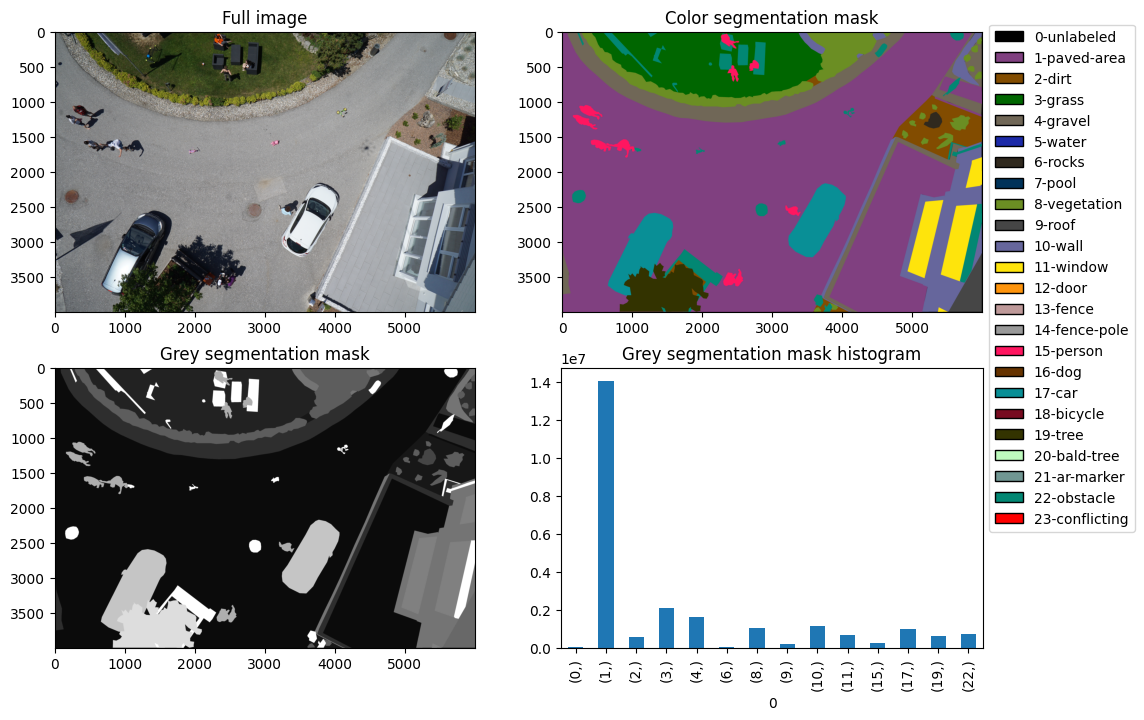

In [9]:
# Check one image
PATH_images = "data/08 - Aerial data/dataset/semantic_drone_dataset/images/original_images"
PATH_masks_color = "data/08 - Aerial data/RGB_color_image_masks/RGB_color_image_masks"
PATH_masks = "data/08 - Aerial data/dataset/semantic_drone_dataset/masks/label_images_semantic"
image_index = 16

image = imread(os.path.join(PATH_images,os.listdir(PATH_images)[image_index]))
mask_color = imread(os.path.join(PATH_masks_color,os.listdir(PATH_masks_color)[image_index]))
mask = imread(os.path.join(PATH_masks,os.listdir(PATH_masks)[image_index]))

# Plot images
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
ax[0][0].imshow(image)
ax[0][1].imshow(mask_color)
ax[0][0].set_title("Full image")
ax[0][1].set_title("Color segmentation mask")
ax[1][0].imshow(mask,cmap="gray")
pd.DataFrame(mask.ravel()).value_counts().sort_index().plot.bar(ax=ax[1,1])
ax[1][0].set_title("Grey segmentation mask")
ax[1][1].set_title("Grey segmentation mask histogram")
# Create a legend from the labels and their respective colors.
legend_elements = []
for i, label in labels.iterrows():
    legend_elements.append(Patch(facecolor=(label.values[1]/255., label.values[2]/255., label.values[3]/255.), edgecolor='k',
                         label = str(i) + "-" + label.values[0]))

ax[0][1].legend(handles=legend_elements, bbox_to_anchor=(1.38, 1.05))

We can see that the image has high resolution (4000 x 6000) and the objects are clearly segmented for the training. We can mostly see paved road in purple, but also grass in green, cars in turqoise, people in red, windows in yellow and many more.

The image mask on top right is from the "RGB_color_image_masks"-folder, where the mask has clearly different colors, which are a combination of 255 values for each channel of RGB. However, for training we use the masks from "label_images_semantic"-folder, which has the same masks but instead of RGB colors the different segments have values from 0 to 23. This way we can have one image with 24 different channels for training. On bottom right you can see the histogram of the different classes, here the value 1 (which corresponds to the paved area) dominates the photo.

Since the dataset is quite small (400 photos) we want to augment the data a lot for the training. Since we are dealing with top-down images without any correct direction, we can rotate the image any number of degrees and get a nice new training image. Keras' functions are too slow for us, but luckily the "albumentations"-library provides fast image augmentation for computer vision tasks. Let's create a function that deals with the augmentations. We want square images, and since my computer can't handle 4000x4000 training, I scale the images down as well. We randomly rotate the photos as well as flip and change the brightness and contrast.

Loading a full 6000x4000 photo and doing augmentations to it would take too much time and resources, so we load them downscaled and do augmentations. However, if we load them as 512x512, rotate them by 45 degrees and crop to a square again, we'd either have to crop the borders resulting in a really small area in the center or interpolate the missing areas. However, if we load the images as 768 x 768, then we can rotate by 45 degrees and then crop out the borders, ending up with a 543 x 543 image without any parts missing. Finally we scale them down to 512x512.

In [3]:
def augment(SIZE=512):
    transform = A.Compose([
#        A.Rotate(limit=[0, 359], p=1.0, interpolation=0,crop_border=True, border_mode=0), # rotate arbitrary amount between 0 and 359 degrees
#        A.SmallestMaxSize(max_size=SIZE), # resize so that shorter edge is equal to max_size
#        A.CenterCrop(width=SIZE, height=SIZE, p=1.0), # crop to a square
        A.RandomBrightnessContrast(0.3, 0.3, p=1.0), # randomly change brightnes + contrast
        A.HorizontalFlip(p=0.5), # random hor flip
        A.VerticalFlip(p=0.5), # random vertical flip
        A.RGBShift(p=0.4, r_shift_limit=35/255, g_shift_limit=15/255, b_shift_limit=20/255), # shift colors to imitate sunrise/set. Some green and blue shift too, prob 40%
        A.ToFloat(),
#        A.RandomSnow(p=0.2), # With probability 20%, bleach some pixels to imitate snow 
#        A.ISONoise(p=1.0), 
#        A.MotionBlur(p=1.0),
#        A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=1),
#        A.GridDistortion(p=0.5),
#        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
#        A.OneOf([
#            A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=1),
#            A.GridDistortion(p=0.5),
#            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
#        ], p=1.0),
    ], p=1.0)
    
    return transform

In [4]:
# This and next cell is to test the augmentation speed for one image
PATH_images = "data/08 - Aerial data/dataset/semantic_drone_dataset/images/original_images"
PATH_masks = "data/08 - Aerial data/dataset/semantic_drone_dataset/masks/label_images_semantic"

SIZE = 256

image = img_to_array(
                load_img(
                    os.path.join(PATH_images,os.listdir(PATH_images)[16]),target_size=(SIZE,SIZE),keep_aspect_ratio=True)
        )/255.
mask = img_to_array(
                            load_img(os.path.join(PATH_masks,os.listdir(PATH_masks)[16]),
                                     target_size=(SIZE,SIZE),keep_aspect_ratio=True, color_mode="grayscale"
                                        )
                                    )


In [6]:
%%timeit
# Check how long one augmentation takes
transform = augment()
transformed = transform(image=image, mask=mask)

10.6 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's randomly do three different augmentations to the image and see the results. First column shows the orignal image and mask, the three last  columns show three different augmentations of the image and their corresponding masks.

CPU times: total: 1.11 s
Wall time: 1.1 s


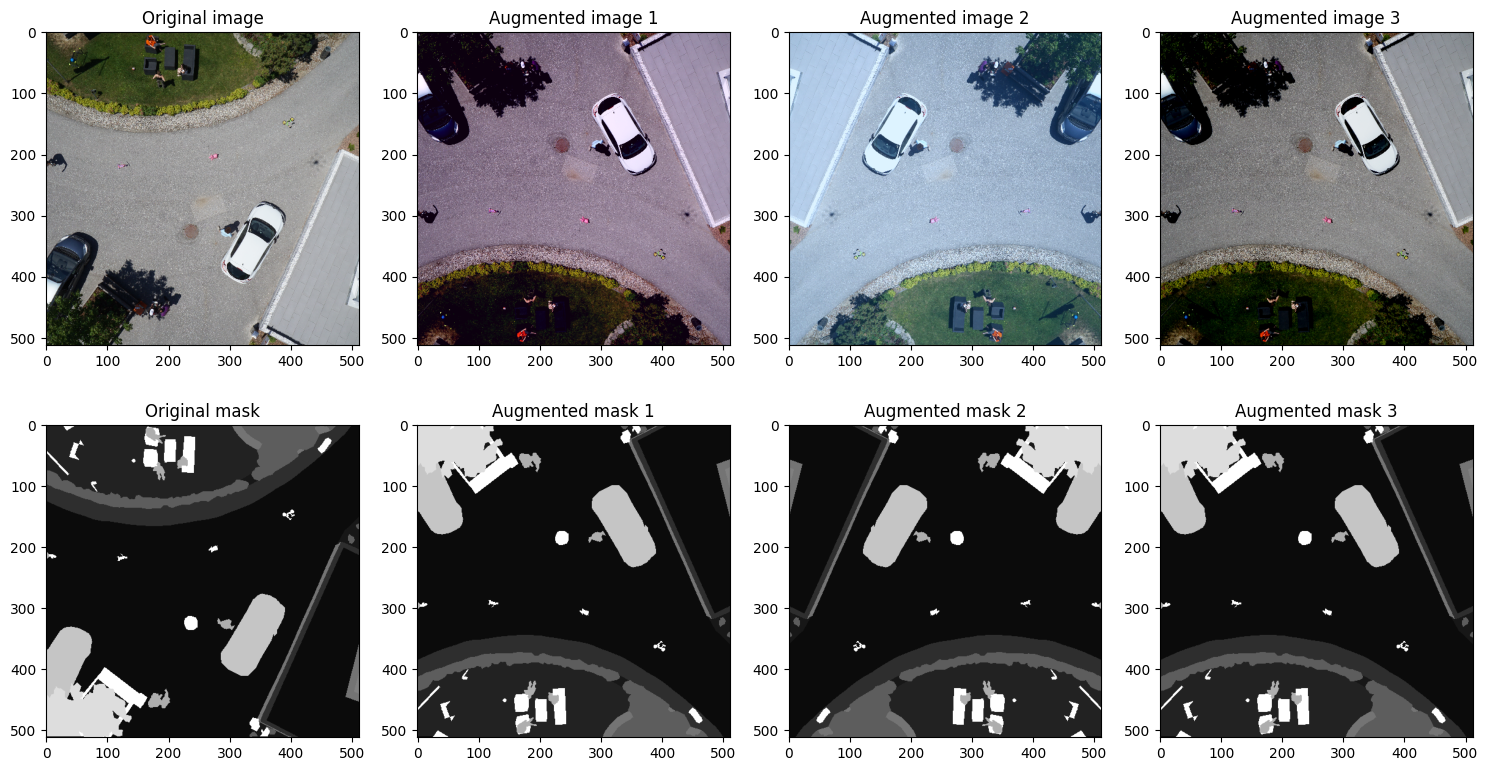

In [12]:
%%time
PATH_images = "data/08 - Aerial data/dataset/semantic_drone_dataset/images/original_images"
PATH_masks = "data/08 - Aerial data/dataset/semantic_drone_dataset/masks/label_images_semantic"

SIZE = 512

image = img_to_array(
                load_img(
                    os.path.join(PATH_images,os.listdir(PATH_images)[16]),target_size=(SIZE,SIZE),keep_aspect_ratio=True
                        )
                    )/255.
mask = img_to_array(
                load_img(os.path.join(PATH_masks,os.listdir(PATH_masks)[16]),
                         target_size=(SIZE,SIZE),keep_aspect_ratio=True, color_mode="grayscale"
                        )
                    )

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,8))
axes[0][0].imshow(image)
axes[1][0].imshow(mask,cmap="gray")
axes[0][0].set_title("Original image")
axes[1][0].set_title("Original mask")
transform = augment()
for i in range(1, 4):
    transformed = transform(image=image, mask=mask)
    transformed_image = transformed['image']
    transformed_mask = transformed['mask']
    
    axes[0][i].imshow(transformed_image)
    axes[1][i].imshow(transformed_mask,cmap="gray")

    axes[0][i].set_title(f"Augmented image {i}")
    axes[1][i].set_title(f"Augmented mask {i}")
plt.tight_layout()

Albumentations pipelines can be implemented to work with Tensorflow's dataset classes. However, I couldn't find a working solution for this when using masks (it did different augmentations for the image and the mask). Therefore, let's implement our own preprocessing function and DataGenerator class.

The preprocessing function loads the images and masks in one batch, augments them and outputs them in the correct batch format. In order to keep the data loading and augmentation as quick as possible (now seems to be the bottleneck), the function should handle the processing with as few loops and variables as possible. Since Albumentations can't seem to receive multiple images as inputs, we need to loop the augmentations one by one.

In [82]:
def augment_valid(SIZE=512):
    transform_valid = A.Compose([
        A.SmallestMaxSize(max_size=SIZE), # resize so that shorter edge is equal to max_size
        A.ToFloat(),
    ], p=1.0)
    return transform_valid

In [83]:
def preprocess_files(batch_image, batch_mask, path_image, path_mask, batch_size, SIZE_load, SIZE_final, n_output, subset):
    augmented_images = []
    augmented_masks = []
    if subset=="training":
        transform = augment(SIZE_load)
    elif subset=="validation":
        transform = augment_valid(SIZE_load)
        
    for file_img, file_mask in zip(batch_image, batch_mask):

            
        transformed = transform(image = img_to_array(load_img(
                                    os.path.join(os.path.abspath(path_image),file_img),target_size=(SIZE_load,SIZE_load),keep_aspect_ratio=True
                                ))/255.,
                                mask = img_to_array(
                                tf.one_hot(
                                    img_to_array(
                                        load_img(os.path.join(os.path.abspath(path_mask),file_mask),
                                                 target_size=(SIZE_load,SIZE_load),keep_aspect_ratio=True, color_mode="grayscale"
                                        )
                                    )[:,:,0], n_output, dtype=tf.int32))
                               )
        augmented_images.append(transformed["image"])
        augmented_masks.append(transformed["mask"])        
        
    return np.resize(augmented_images, (batch_size,SIZE_final,SIZE_final,3)), np.resize(augmented_masks, (batch_size,SIZE_final,SIZE_final,n_output))

The datagenerator splits and shuffles the input files, divides them into batches and preprocesses them. 

In [84]:
class DataGenerator(Sequence):

    def __init__(self, x_set, y_set, batch_size, image_size_load, image_size_final, n_output, subset, val_split):
        random.seed(None)
        rand = random.random()

        x_files = os.listdir(x_set)
        y_files = os.listdir(y_set)
        
        random.seed(rand)
        random.shuffle(x_files)

        random.seed(rand)
        random.shuffle(y_files)

        split_index = round(len(os.listdir(x_set))*(1-val_split))
        if subset=="training":
            x_files = x_files[:split_index]
        elif subset=="validation":
            x_files = x_files[split_index:]

        if subset=="training":
            y_files = y_files[:split_index]
        elif subset=="validation":
            y_files = y_files[split_index:]

        self.x, self.y = x_files, y_files
        
        self.batch_size = batch_size
        self.image_size_load = image_size_load
        self.image_size_final = image_size_final
        self.n_output = n_output
        self.path_input = x_set
        self.path_label = y_set
        self.subset = subset

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)


    def __getitem__(self, idx):        
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x, batch_y = preprocess_files(batch_x, batch_y, self.path_input, self.path_label, self.batch_size, 
                                            self.image_size_load, self.image_size_final, self.n_output, self.subset)
        
        return batch_x, batch_y


In [90]:
seed = 1
image_size_load = 256 # Scale images to 768x768 when loading, then rotate and scale further to image_size_final before training
image_size_final = 256 # Final image size
batch_size = 6
val_split = 0.10 # Use 10% of the data as validation
n_output = 24

PATH_images = "data/08 - Aerial data/dataset/semantic_drone_dataset/images/original_images"
PATH_masks = "data/08 - Aerial data/dataset/semantic_drone_dataset/masks/label_images_semantic"

training_generator = DataGenerator(PATH_images, PATH_masks, batch_size, image_size_load, image_size_final, n_output, "training", val_split)
validating_generator = DataGenerator(PATH_images, PATH_masks, batch_size, image_size_load, image_size_final, n_output, "validation", val_split)

In [91]:
print(f"Training steps per epoch: {training_generator.__len__()}")
print(f"Validating steps per epoch: {validating_generator.__len__()}")

Training steps per epoch: 60
Validating steps per epoch: 7


Let's load the first image and its mask from the training generator to check the batch dimensions, augmentation and masks are ok. In order to color the mask with the given colors for each class, we can create a colormap from the RGB values and use that to map the indices of the mask to colors.

In [92]:
cmap = np.array(list(labels[[' r', ' g', ' b']].transpose().to_dict('list').values()))
cmap

array([[  0,   0,   0],
       [128,  64, 128],
       [130,  76,   0],
       [  0, 102,   0],
       [112, 103,  87],
       [ 28,  42, 168],
       [ 48,  41,  30],
       [  0,  50,  89],
       [107, 142,  35],
       [ 70,  70,  70],
       [102, 102, 156],
       [254, 228,  12],
       [254, 148,  12],
       [190, 153, 153],
       [153, 153, 153],
       [255,  22,  96],
       [102,  51,   0],
       [  9, 143, 150],
       [119,  11,  32],
       [ 51,  51,   0],
       [190, 250, 190],
       [112, 150, 146],
       [  2, 135, 115],
       [255,   0,   0]])

Image batch dimensions: (6, 512, 512, 3)
Mask shape: (512, 512, 24)
One mask image: (512, 512)
CPU times: total: 3.22 s
Wall time: 3.27 s


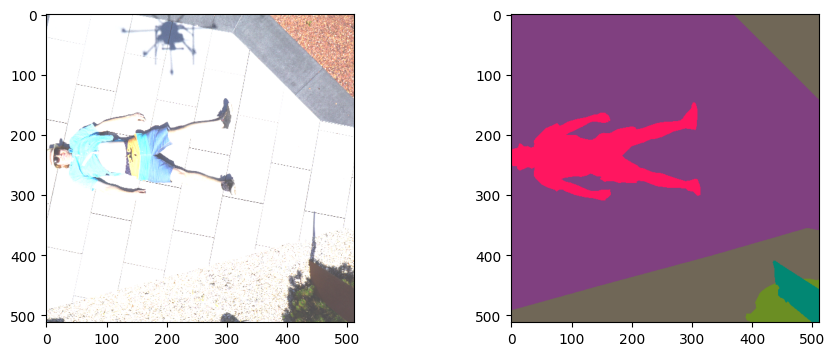

In [19]:
%%time
imagebatch = training_generator.__getitem__(0)
print(f"Image batch dimensions: {imagebatch[0].shape}")
image = imagebatch[0][0,:,:,:]

mask = imagebatch[1][0,:,:,:]
print(f"Mask shape: {mask.shape}")
# To get one value per pixel, take the argmax on the third axis (so 512x512x24 reduces to 512x512)
mask_rgb = np.argmax(mask, axis=2)
print(f"One mask image: {mask_rgb.shape}")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
axes[0].imshow(image)
axes[1].imshow(cmap[mask_rgb])

Image batch dimensions: (6, 512, 512, 3)
Mask shape: (512, 512, 24)
One mask image: (512, 512)
CPU times: total: 3.14 s
Wall time: 3.06 s


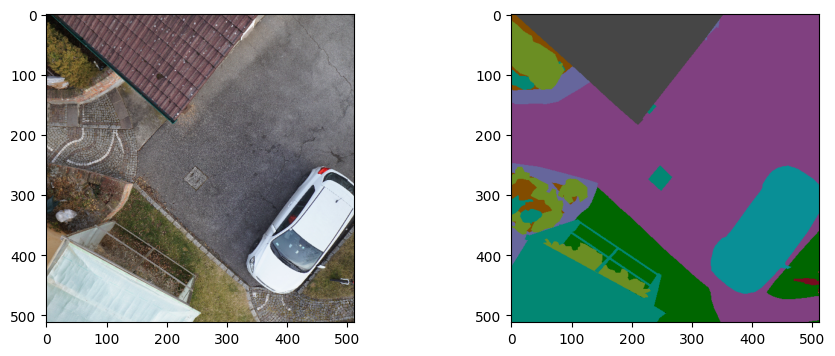

In [20]:
%%time
imagebatch = validating_generator.__getitem__(0)
print(f"Image batch dimensions: {imagebatch[0].shape}")
image = imagebatch[0][0,:,:,:]

mask = imagebatch[1][0,:,:,:]
print(f"Mask shape: {mask.shape}")
# To get one value per pixel, take the argmax on the third axis (so 512x512x24 reduces to 512x512)
mask_rgb = np.argmax(mask, axis=2)
print(f"One mask image: {mask_rgb.shape}")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
axes[0].imshow(image)
axes[1].imshow(cmap[mask_rgb])

In [93]:
# Define the U-net architecture. Typically it consists of many blocks that first go "down" as the encoder 
# and then come "up" and the decoder. Since the blocks are similar in layers, we can compress them by 
# recursively building the model from conv and level blocks. 

# HeUniform initializer for the initial values of the neurons have been found to improve training.
initializer = HeUniform(seed=seed)

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same', kernel_initializer=initializer)(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same', kernel_initializer=initializer)(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n
	
def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res, do)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same', kernel_initializer=initializer)(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same', kernel_initializer=initializer)(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res, do)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def model_unet(img_shape, start_ch=8, dropout=0.1, batchnorm=False, out_ch=3, depth=5, 
		   inc_rate=2., activation='relu', maxpool=False, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='softmax')(o)
	return Model(inputs=i, outputs=o)

Let's define and compile the model with categorical crossentropy as loss metric. Since we are working with higher resolution images and multiple output classes, let's set the depth of the model to 4.

In [94]:
# defining the parameters for the model
SIZE = image_size_final
n_input = 3 # input channels, RGB
KERNEL_SIZE = n_output
DEPTH = 3 # depth of the U-net model
DROPOUT = 0.05
BATCHNORM = True

# Build model, use Adam optimizer and the dice coefficient as loss function
model = model_unet([SIZE,SIZE,n_input], KERNEL_SIZE, dropout=DROPOUT, batchnorm=BATCHNORM, out_ch=n_output, depth=DEPTH)

model.compile(optimizer = Adam(learning_rate=0.0025), 
              loss = "categorical_crossentropy",
              metrics = 'accuracy',
             run_eagerly=False)

In [95]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_84 (Conv2D)          (None, 256, 256, 24)         672       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_56 (Ba  (None, 256, 256, 24)         96        ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_7 (Dropout)         (None, 256, 256, 24)         0         ['batch_normalization_56

From the model output shapes we can see that we start with 512 x 512 RGB images. The model passes the images "down" through convolutional layers until we end up with 32 x 32 images with 368 channels. This is then upsampled and concatenated "upwards" with the earlier layers until we get as an output 512 x 512 images with 23 channels, each corresponding to one segmentation class.

Let's set up callback functions for learning rate scheduler, halving LR on plateau and logging results to csv. Then let's start training for 10 epochs first.

In [96]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

In [97]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, LearningRateScheduler

LRS = LearningRateScheduler(scheduler)

# Let's define some callbacks for the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

# Log results to a CSV file
csv_logger = CSVLogger(f'checkpoints/train_log_aerial.csv', append=True, separator=';')

In [98]:
# Save results also in this DF
history_df = pd.DataFrame()

In [99]:
init_epoch = 0
epochs = 10

for epoch in range(1,epochs+1):
    # Saving the best model checkpoint
    checkpoint_filepath = f"checkpoints/cp-epoch_{epoch}.ckpt"
    cp_callback = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, verbose=1)
    callbacklist = [cp_callback, csv_logger, LRS]
    
    history = model.fit(training_generator,
                        epochs=epoch,
                        steps_per_epoch = training_generator.__len__(),
                        validation_data = validating_generator, 
                        validation_steps = validating_generator.__len__(),
                        initial_epoch = init_epoch,
                       workers=1,
                       callbacks=callbacklist)
    init_epoch = epoch
    if history_df.empty:
        history_df = pd.DataFrame(history.history)
    else:
        history_df = pd.concat([history_df,pd.DataFrame(history.history)],ignore_index=True)

60/60 [==============================] - ETA: 0s - loss: 2.3506 - accuracy: 0.4547
Epoch 1: saving model to checkpoints\cp-epoch_1.ckpt
60/60 [==============================] - 172s 3s/step - loss: 2.3506 - accuracy: 0.4547 - val_loss: 68.7284 - val_accuracy: 0.0426 - lr: 0.0025
Epoch 2/2
60/60 [==============================] - ETA: 0s - loss: 1.8897 - accuracy: 0.5307
Epoch 2: saving model to checkpoints\cp-epoch_2.ckpt
60/60 [==============================] - 161s 3s/step - loss: 1.8897 - accuracy: 0.5307 - val_loss: 3.4639 - val_accuracy: 0.3821 - lr: 0.0025
Epoch 3/3
60/60 [==============================] - ETA: 0s - loss: 1.7737 - accuracy: 0.5319
Epoch 3: saving model to checkpoints\cp-epoch_3.ckpt
60/60 [==============================] - 172s 3s/step - loss: 1.7737 - accuracy: 0.5319 - val_loss: 4.5893 - val_accuracy: 0.2106 - lr: 0.0025
Epoch 4/4
60/60 [==============================] - ETA: 0s - loss: 1.6198 - accuracy: 0.5457
Epoch 4: saving model to checkpoints\cp-epoch_4.c

In [60]:
history_df = pd.read_csv("checkpoints/train_log_aerial.csv",delimiter=";",index_col=0)
history_df

accuracy      loss  val_accuracy       val_loss
epoch                                                 
0      0.445832  2.369794      0.006017     371.744293
1      0.538822  1.914841      0.033797      20.420261
2      0.546018  1.734343      0.118746       3.727674
3      0.555883  1.614348      0.263024       2.472180
4      0.551498  1.635035      0.321817       2.594684
5      0.556256  1.552370      0.293893       2.754418
6      0.555568  1.564713      0.302838       2.376128
7      0.566591  1.466246      0.303570       2.724984
8      0.564088  1.512863      0.297726       2.826182
9      0.582746  1.444292      0.334768       2.385326
10     0.573341  1.489180      0.315691       2.481788
11     0.574511  1.444419      0.363454       3.127512
12     0.571527  1.447720      0.314091       3.608877
13     0.595740  1.392681      0.335921       2.723314
14     0.592531  1.402789      0.373291       2.843405
15     0.600318  1.376426      0.350951       2.904006
16     0.602771  1.363711      0.300617       3.279629
17     0.591760  1.377513      0.261690       3.941473
18     0.600122  1.356291      0.347218       3.576149
19     0.573116  1.407449      0.353915       3.226009
0      0.423427  2.451977      0.038132  133134.906250
1      0.538418  1.847714      0.003129    1717.285767
2      0.541043  1.737017      0.023859     126.707321
3      0.545216  1.655963      0.222869       4.387807
4      0.542595  1.596723      0.312317       4.572845
5      0.565222  1.527730      0.294847       2.214805
6      0.562627  1.531414      0.384044       2.962780
7      0.581279  1.499429      0.279641       5.624831
8      0.556876  1.497775      0.413775       1.889083
9      0.574661  1.476802      0.419089       1.779303

In [100]:
history_df

loss  accuracy   val_loss  val_accuracy        lr
0  2.350645  0.454711  68.728401      0.042644  0.002500
1  1.889711  0.530657   3.463883      0.382066  0.002500
2  1.773677  0.531883   4.589254      0.210582  0.002500
3  1.619818  0.545715   2.132097      0.478709  0.002475
4  1.574299  0.553627   1.570841      0.531000  0.002450
5  1.594227  0.548636   1.521435      0.535316  0.002426
6  1.535561  0.561949   1.436025      0.570335  0.002402
7  1.546288  0.558792   1.439160      0.556613  0.002378
8  1.502843  0.565402   1.417639      0.589170  0.002354
9  1.499076  0.558233   1.368503      0.582039  0.002331

In [61]:
init_epoch = 10

In [200]:
epoch = init_epoch
checkpoint_filepath = f"checkpoints/cp-epoch_{epoch}.ckpt"
cp_callback = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, verbose=1)
callbacklist = [cp_callback, csv_logger, LRS]

The training looks like it's going well. Let's train for 50 more epochs.

In [201]:
# Train more

epochs = 1

history_more = model.fit(training_generator,
                    epochs=init_epoch+epochs,
                    steps_per_epoch = training_generator.__len__(),
                    validation_data = validating_generator, 
                    validation_steps = validating_generator.__len__(),
                    initial_epoch = init_epoch,
                   workers=1,
                   callbacks=callbacklist)

init_epoch = init_epoch+epochs

history_df = pd.concat([history_df,pd.DataFrame(history_more.history)],ignore_index=True)
history_df

Epoch 310/310
60/60 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.8373
Epoch 310: saving model to checkpoints\cp-epoch_309.ckpt
60/60 [==============================] - 175s 3s/step - loss: 0.5294 - accuracy: 0.8373 - val_loss: 0.4866 - val_accuracy: 0.8465 - lr: 1.1605e-04


loss  accuracy   val_loss  val_accuracy        lr
0    2.350645  0.454711  68.728401      0.042644  0.002500
1    1.889711  0.530657   3.463883      0.382066  0.002500
2    1.773677  0.531883   4.589254      0.210582  0.002500
3    1.619818  0.545715   2.132097      0.478709  0.002475
4    1.574299  0.553627   1.570841      0.531000  0.002450
..        ...       ...        ...           ...       ...
305  0.518658  0.840545   0.563493      0.817114  0.000121
306  0.543375  0.832294   0.487339      0.849592  0.000120
307  0.534771  0.836252   0.487432      0.847499  0.000118
308  0.532251  0.837412   0.484352      0.847195  0.000117
309  0.529436  0.837289   0.486592      0.846510  0.000116

[310 rows x 5 columns]

<Axes: >

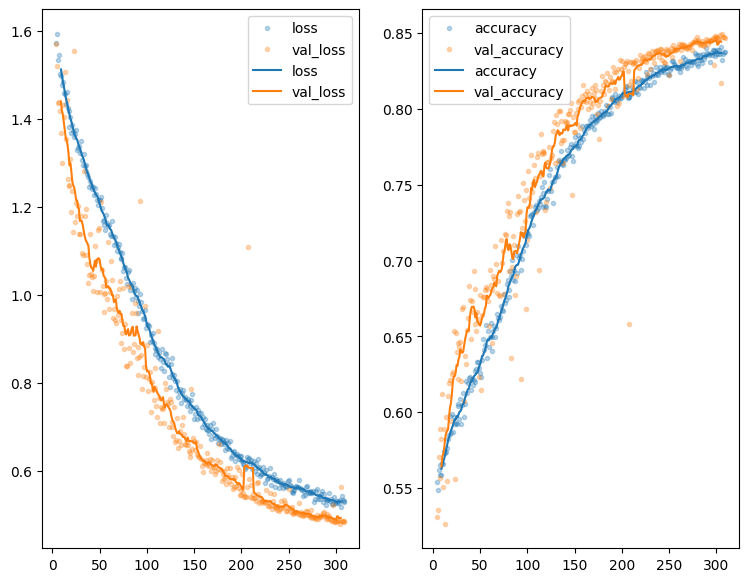

In [205]:
# Plot training results
fig, axes = plt.subplots(1, 2, figsize = (9, 7))
offset = 4
history_df.iloc[offset:][["loss","val_loss"]].plot(ax=axes[0],lw=0,marker=".",alpha=0.3, color=["C0","C1"])
history_df.iloc[offset:][["loss","val_loss"]].rolling(10,center=True).mean().plot(ax=axes[0], color=["C0","C1"])

history_df.iloc[offset:][["accuracy","val_accuracy"]].plot(ax=axes[1],lw=0,marker=".",alpha=0.3, color=["C0","C1"])
history_df.iloc[offset:][["accuracy","val_accuracy"]].rolling(10,center=True).mean().plot(ax=axes[1], color=["C0","C1"])

<Axes: >

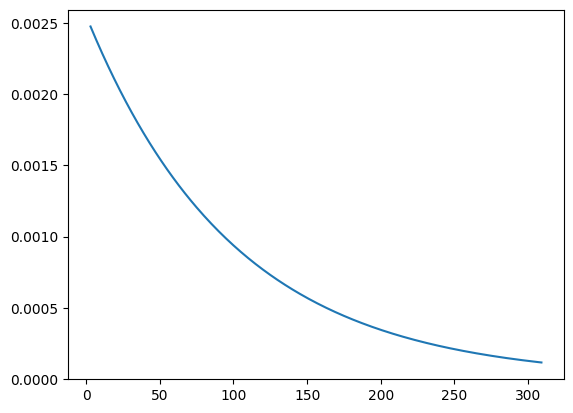

In [203]:
history_df.iloc[offset:].lr.plot()

The model learned and the losses decreased until the end. The callback saved the best model. We can check its index and load it.

In [204]:
best_model_index = history_df.val_loss.sort_values(ascending=False).index[-1]
print(best_model_index)

304


In [34]:
best_model_index = 45
cp_file_name = f"checkpoints/cp-epoch_{best_model_index}.ckpt"
model.load_weights(cp_file_name)

### Evaluation and prediction

Predicting three masks from the training set and validation to see how well the model learned.

1/1 [==============================] - 0s 90ms/step


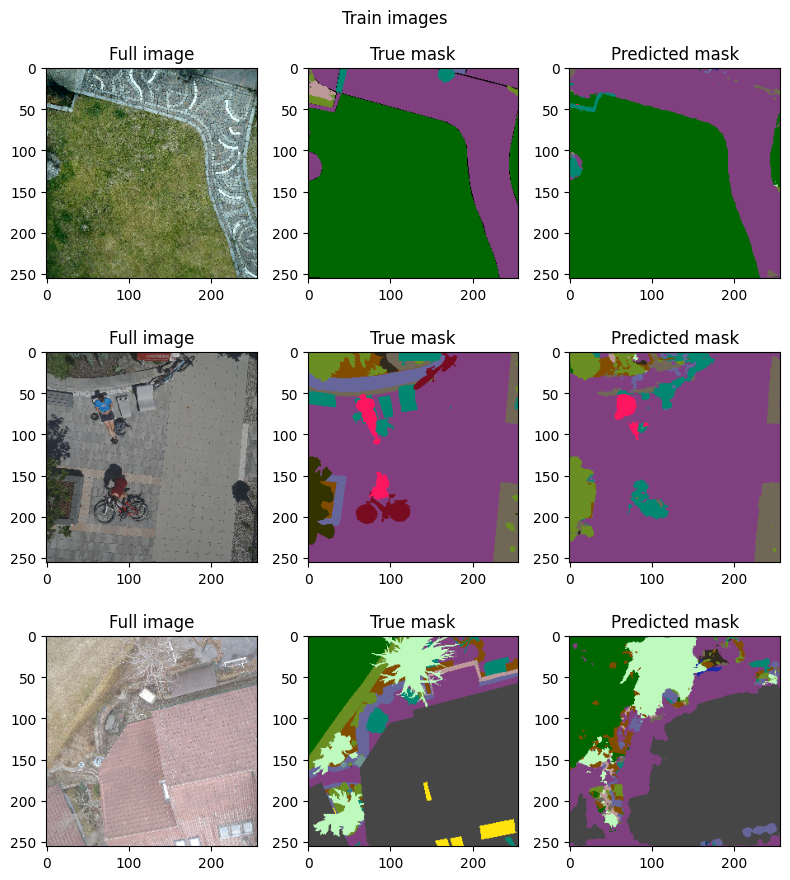

In [208]:
offset = 1
images, masks = training_generator.__getitem__(offset)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,9))
for i in range(3):
    img_lung = images[i,:,:,:]
    img_mask = masks[i,:,:,:]
    img_mask = np.argmax(img_mask, axis=2)/255. # generator mask is (size,size,23), scale back to greyscale
    
    img_lung_array = img_to_array(img_lung)
    to_predict = img_lung_array.reshape((1, img_lung_array.shape[0], img_lung_array.shape[1], img_lung_array.shape[2]))
    predicted = model.predict(to_predict)
    predicted = np.argmax(predicted, axis=3).reshape(image_size_final, image_size_final,1)[:,:,0]
    
    ax[i][0].imshow(img_lung)
    ax[i][1].imshow(cmap[(img_mask*255).astype(int)],cmap="gray")
    ax[i][2].imshow(cmap[(predicted).astype(int)],cmap="gray")
    ax[i][0].set_title("Full image")
    ax[i][1].set_title("True mask")
    ax[i][2].set_title("Predicted mask")
fig.suptitle("Train images")
plt.tight_layout()

1/1 [==============================] - 0s 85ms/step


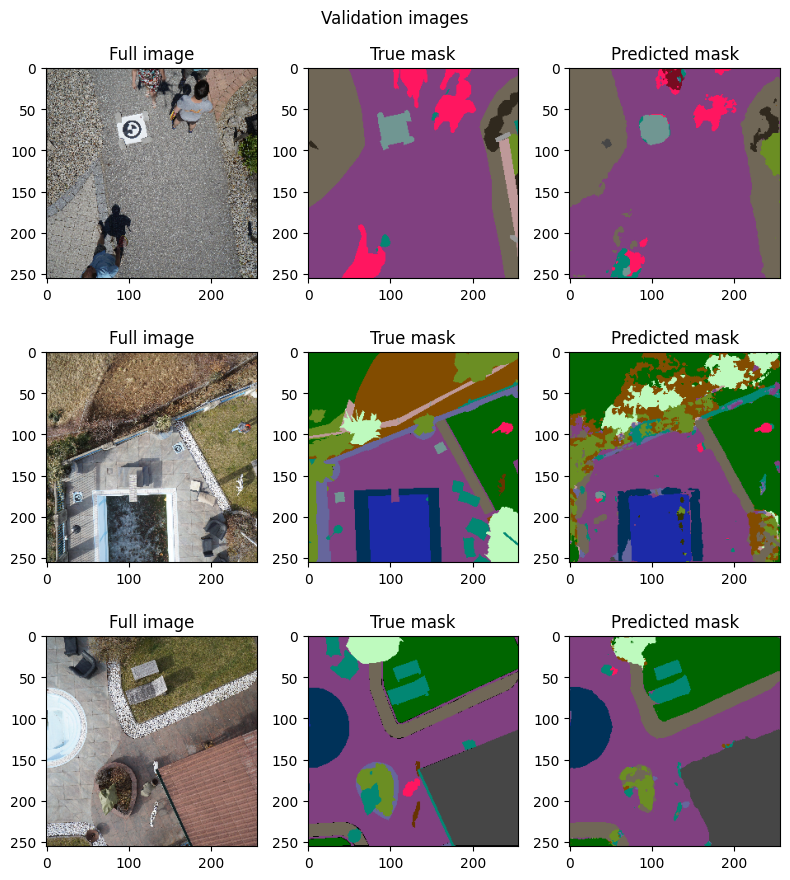

In [209]:
offset = 1
images, masks = validating_generator.__getitem__(offset)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,9))
for i in range(3):
    img_lung = images[i,:,:,:]
    img_mask = masks[i,:,:,:]
    img_mask = np.argmax(img_mask, axis=2)/255. # generator mask is (size,size,23), scale back to greyscale
    
    img_lung_array = img_to_array(img_lung)
    to_predict = img_lung_array.reshape((1, img_lung_array.shape[0], img_lung_array.shape[1], img_lung_array.shape[2]))
    predicted = model.predict(to_predict)
    predicted = np.argmax(predicted, axis=3).reshape(image_size_final, image_size_final,1)[:,:,0]
    
    ax[i][0].imshow(img_lung)
    ax[i][1].imshow(cmap[(img_mask*255).astype(int)],cmap="gray")
    ax[i][2].imshow(cmap[(predicted).astype(int)],cmap="gray")
    ax[i][0].set_title("Full image")
    ax[i][1].set_title("True mask")
    ax[i][2].set_title("Predicted mask")
fig.suptitle("Validation images")
plt.tight_layout()

Let's check the histograms of the last mask and prediction, i.e. how many pixels are in each class.

<Axes: title={'center': 'Number of pixels in each class'}, xlabel='name'>

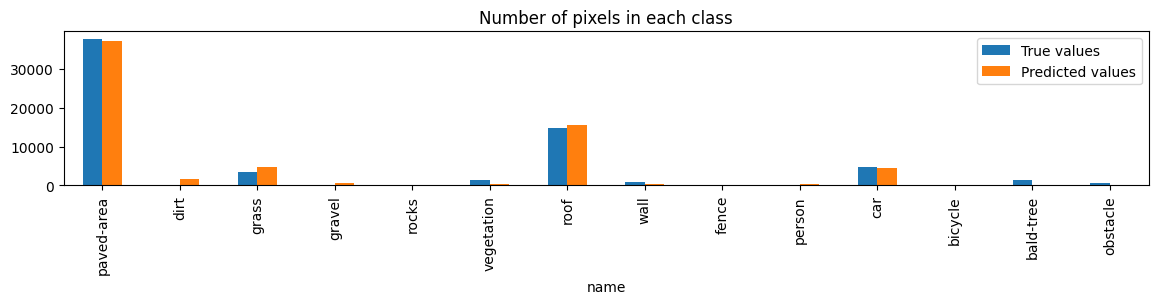

In [170]:
true_hist = pd.DataFrame((img_mask.ravel()*255).astype(int)).value_counts()
pred_hist = pd.DataFrame(predicted.ravel().astype(int)).value_counts()
both = pd.concat([true_hist,pred_hist],axis=1).sort_index()

both.columns = ["True values", "Predicted values"]
both = both.set_index(labels.name[both.reset_index()[0].values]) # change index to labels

both.plot.bar(figsize=(14,2),title="Number of pixels in each class")

Based on these three images, it learned the mask area quite well, although it didn't get all small details from the first and last image.

The model performs well on the validation set (which the model wasn't trained on) as well. It clearly detects the tumor areas and gives high dice coefficients, however in the second image it also detects something extra that isn't a tumor and results in slightly lower dice coefficient.

The model could be improved by:
- Finding better parameters for the u-net model and training
- Using full image size
- Training more with things like learning rate scheduler that automatically reduces the learning rate during training.
- Using more data

However, for a smallish dataset of 3000 photos, photo sizes of 128x128 and just 20 minutes of training, I think the model performs surprisingly well.

In [210]:
test_image = img_to_array(
                load_img("test.png",target_size=(SIZE,SIZE),keep_aspect_ratio=True))/255.

1/1 [==============================] - 0s 86ms/step


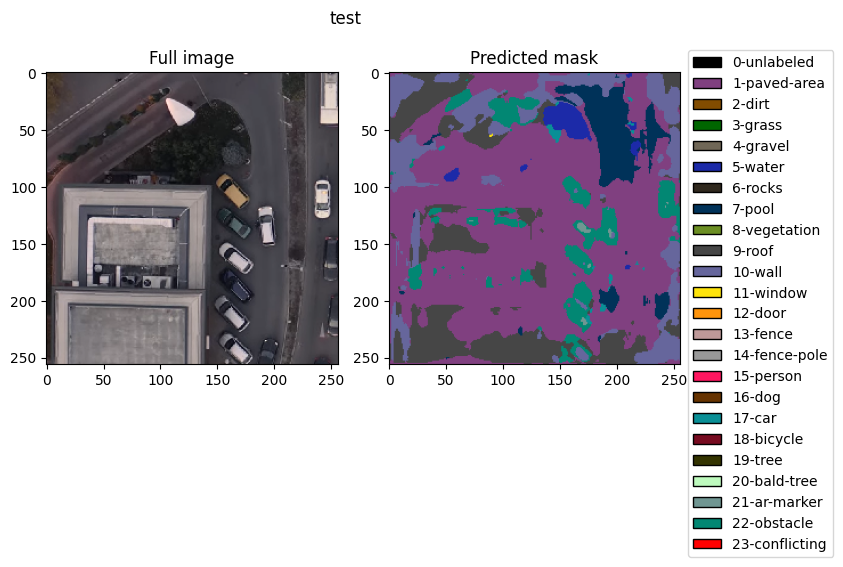

In [215]:
test_image = img_to_array(
                load_img("test4.png",target_size=(SIZE,SIZE),keep_aspect_ratio=True))/255.

to_predict = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
predicted = model.predict(to_predict)
predicted = np.argmax(predicted, axis=3).reshape(image_size_final, image_size_final,1)[:,:,0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,4))

# Create a legend from the labels and their respective colors.
legend_elements = []
for i, label in labels.iterrows():
    legend_elements.append(Patch(facecolor=(label.values[1]/255., label.values[2]/255., label.values[3]/255.), edgecolor='k',
                         label = str(i) + "-" + label.values[0]))

ax[0].imshow(test_image)
ax[1].imshow(cmap[(predicted).astype(int)],cmap="gray")
ax[0].set_title("Full image")
ax[1].set_title("Predicted mask")
fig.suptitle("test")
plt.tight_layout()
ax[1].legend(handles=legend_elements, bbox_to_anchor=(1.55, 1.1))

<Axes: xlabel='epoch'>

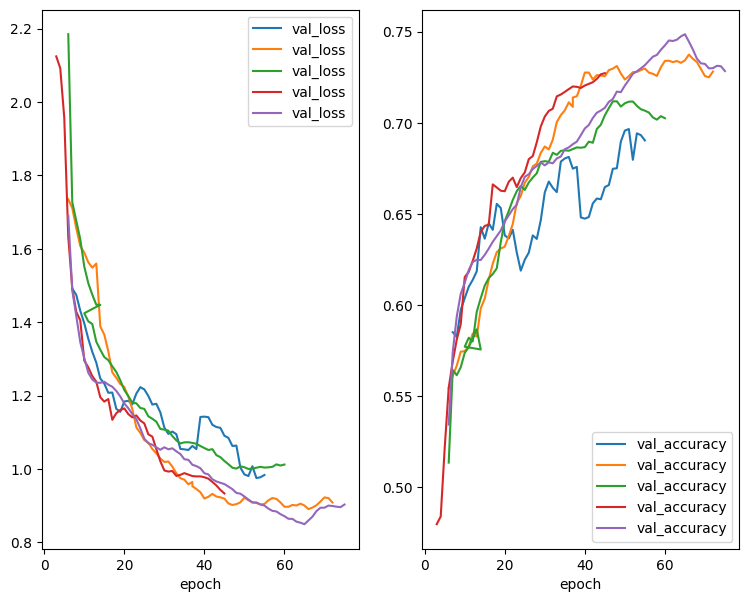

In [31]:
hist_final = pd.read_csv("checkpointsfinal/train_log_aerial.csv",delimiter=";",index_col=0)
hist_bn = pd.read_csv("checkpoints512bn/train_log_aerial.csv",delimiter=";",index_col=0)
hist_final2 = pd.read_csv("checkpointsfinal2/train_log_aerial.csv",delimiter=";",index_col=0)
hist_final3 = pd.read_csv("checkpointsfinal3/train_log_aerial.csv",delimiter=";",index_col=0)

fig, axes = plt.subplots(1, 2, figsize = (9, 7))
history_df.iloc[offset:][["val_loss"]].rolling(10,center=True).mean().plot(ax=axes[0])
history_df.iloc[offset:][["val_accuracy"]].rolling(10,center=True).mean().plot(ax=axes[1])

hist_final.drop(0)[["val_loss"]].rolling(10,center=True).mean().plot(ax=axes[0])
hist_final.drop(0)[["val_accuracy"]].rolling(10,center=True).mean().plot(ax=axes[1])

hist_bn.drop(0)[["val_loss"]].rolling(10,center=True).mean().plot(ax=axes[0])
hist_bn.drop(0)[["val_accuracy"]].rolling(10,center=True).mean().plot(ax=axes[1])

hist_final2.drop(0)[["val_loss"]].rolling(10,center=True).mean().plot(ax=axes[0])
hist_final2.drop(0)[["val_accuracy"]].rolling(10,center=True).mean().plot(ax=axes[1])

hist_final3.drop(0)[["val_loss"]].rolling(10,center=True).mean().plot(ax=axes[0])
hist_final3.drop(0)[["val_accuracy"]].rolling(10,center=True).mean().plot(ax=axes[1])

In [142]:
prev_hist

accuracy      loss  val_accuracy  val_loss
epoch                                            
0      0.486888  2.217866      0.260468  5.691230
1      0.577759  1.642129      0.505712  1.940456
2      0.598857  1.492648      0.552287  1.806574
3      0.607488  1.400407      0.563474  1.758354
4      0.609530  1.352818      0.636741  1.365773
...         ...       ...           ...       ...
72     0.724086  0.918758      0.710949  0.945999
73     0.721320  0.934662      0.710342  0.975701
74     0.725535  0.917121      0.712933  0.951379
75     0.720209  0.933274      0.722660  0.893973
76     0.727627  0.915507      0.766215  0.822757

[78 rows x 4 columns]